In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time
import os
import scanpy as sc
%matplotlib inline

### UMI 4


In [2]:
umi_probs_length_4 = pd.read_csv('/data/dagyeman/cellranger/bam_file_analysis/umi_probs_length_4.tsv', sep='\t', header=None)
umi_probs_length_4.columns = ['umi', 'prob']

In [5]:
umi_prob_arr = np.array(umi_probs_length_4['prob'])

In [14]:
######## forward model for computing expected number of collided UMIs given true n_umis, and an empirical distribution of UMI probabilities
def compute_non_unif_estimator(umi_prob_arr, n_umis_true,K):
    """
    Compute the estimator for non-collided UMI counts.
    
    Parameters:
    umi_prob_arr (numpy.ndarray): Array of UMI probabilities.
    n_umis_true (int): True number of UMIs.
    K (int): Total number of UMIs.
    """
    
    assert len(umi_prob_arr) == K, "Length of umi_prob_arr must be equal to K"
    # assert n_umis_true <= K, "n_umis_true must be less than or equal to K"
    
    # Compute the expected number of UMIs from collisions
    
    return K - np.sum( (1-umi_prob_arr)**n_umis_true )
    
    
def compute_naive_unif_estimator(n_umis_true, K):
    """
    Compute the naive estimator for non-collided UMI counts.
    """
    return K * (1 - (1 - 1 / K)**n_umis_true)

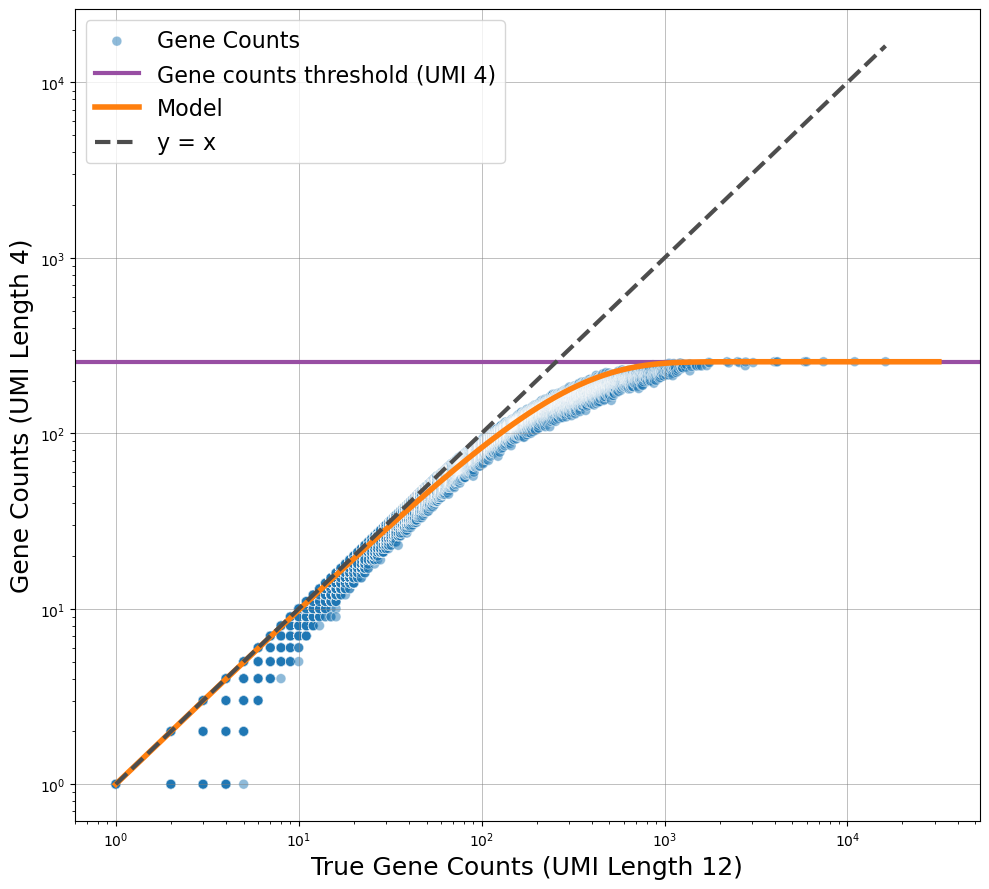

In [36]:
###### Dylan initial plotting code

# directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/"  # Directory for 1k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/"  # Directory for 1k_PBMCs



directory = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/"  # Directory for 10k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/"  # Directory for 10k_PBMCs


# directory = "/data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/"  # Directory for 5k PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ur_objects/adata_matrices/"  # Directory for 5k PBMCs


# directory = "/data/dagyeman/cellranger/bam_file_analysis/500_PBMCs/ub_objects/adata_matrices/"  # Directory for 500 PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/500_PBMCs/ur_objects/adata_matrices/"  # Directory for 500 PBMCs



# directory = "/data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/"  # Directory for 5k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ur_objects/adata_matrices/"  # Directory for 5k_PBMCs

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(directory + f"adata_{i}.h5ad")
    

# Fully remove MALAT1 from adata_dict[5] and adata_dict[12] before plotting
# for k in [4, 12]:
#     if "MALAT1" in adata_dict[k].var_names:
#         adata_dict[k] = adata_dict[k][:, adata_dict[k].var_names != "MALAT1"].copy()





# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
j = 4  # Fixed comparison UMI length
# barcode = "TGTATCTCAGGAATCT-1" # 5k PBMCs 
# barcode = "CAGCAGCTCTCCAATT-1" # 500 PBMCs
n_values = np.logspace(0, 4.5, 200)

min_ct_threshold = 1

# Output directory
# save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/counts_plots/naive"
# os.makedirs(save_dir, exist_ok=True)

# Find the barcode index
# index_i = np.where(adata_dict[i].obs_names == barcode)[0][0]
# index_j = np.where(adata_dict[j].obs_names == barcode)[0][0]

# # Extract and process counts
# gene_counts_i = adata_dict[i].X[index_i].flatten()
# gene_counts_j = adata_dict[j].X[index_j].flatten()

gene_counts_i = adata_dict[i].X.flatten()
gene_counts_j = adata_dict[j].X.flatten()

mask = gene_counts_i >= min_ct_threshold
gene_counts_i = gene_counts_i[mask]
gene_counts_j = gene_counts_j[mask]

sorted_idx = np.argsort(gene_counts_i)
sorted_gene_counts_i = gene_counts_i[sorted_idx] #+ 1
sorted_gene_counts_j = gene_counts_j[sorted_idx] #+ 1

# Create plot
plt.figure(figsize=(10, 9))

# Compute colors based on condition
colors = ["red" if sorted_gene_counts_j[i] - f(sorted_gene_counts_j[i], j) < -40 else '#1f77b4' for i in range(len(sorted_gene_counts_i)) ]


plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j, alpha=0.5, 
            c=colors, edgecolors='w', s=50, linewidth=0.5, label='Gene Counts')

y_asymptotic_value = 4**j
plt.axhline(y=y_asymptotic_value, color='#984ea3', linestyle='-', linewidth=3, label=f'Gene counts threshold (UMI {j})')

model_vals = f(n_values, j)
plt.plot(n_values, model_vals, color='#ff7f0e', linewidth=4, label='Model')

######### also plot results from compute_non_unif_estimator
# K = 4**j
# non_unif_prediction = [compute_non_unif_estimator(umi_prob_arr, n, K) for n in n_values]
# plt.plot(n_values, non_unif_prediction, color='#2ca02c', linewidth=4, label='Non-uniform estimator')



max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_i.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=3, label='y = x')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
plt.ylabel(f'Gene Counts (UMI Length {j})', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.7)
plt.legend(fontsize=16, loc = "upper left")
plt.tight_layout()

plt.show()

In [37]:
###### center plot by subtracting model_vals
K = 4**j
plt.figure()
naive_pred = f(sorted_gene_counts_i,j)
opt_pred = np.array([compute_non_unif_estimator(umi_prob_arr, n, K) for n in sorted_gene_counts_i])
# plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j - opt_pred, alpha=0.5, 
#            c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Counts')
# plt.plot(sorted_gene_counts_i, naive_pred - opt_pred, color='#ff7f0e', linewidth=4, label='uniform minus non-uniform predictions')

# plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j - naive_pred, alpha=0.5, 
#             c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Counts - Naive')

## Uniform one

<Figure size 640x480 with 0 Axes>

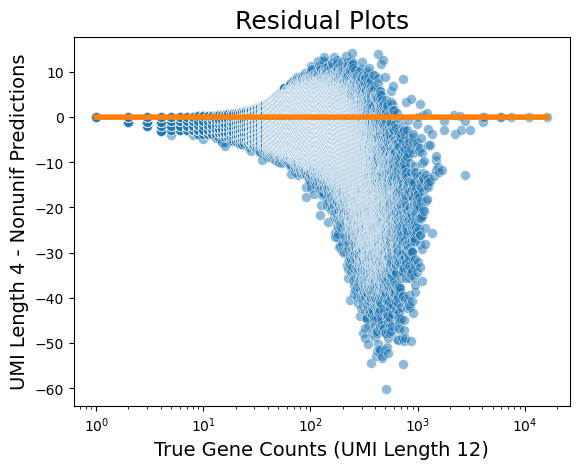

In [38]:
plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j - opt_pred, alpha=0.5, 
            c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Count (UMI Length {j}) - opt_pred')
plt.plot(sorted_gene_counts_i, opt_pred-opt_pred, color='#ff7f0e', linewidth=4, label='Zero Line')
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=14)
plt.ylabel(f'UMI Length {j} - Nonunif Predictions', fontsize=14)
# plt.legend(fontsize=12, loc="lower left", ncol=1, bbox_to_anchor=(0, 0, 0.5, 1))
plt.title(f'Residual Plots', fontsize=18)

plt.xscale('log')

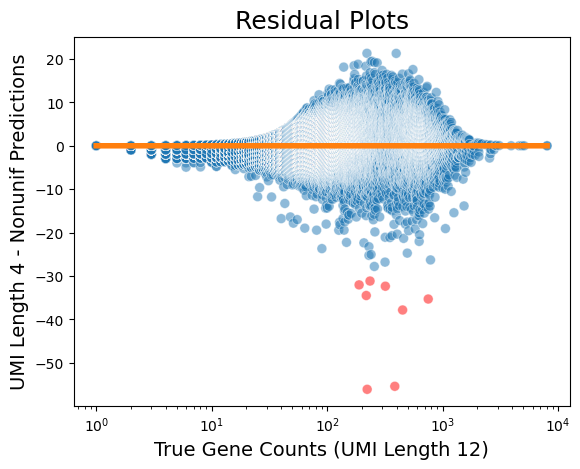

In [35]:
y_values = sorted_gene_counts_j - opt_pred

outlier_threshold = -30
colors = ["red" if y < outlier_threshold else '#1f77b4' for y in y_values]

plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j - opt_pred, alpha=0.5, 
            c=colors, edgecolors='w', s=50, linewidth=0.5, label='Gene Count (UMI Length {j}) - opt_pred')
plt.plot(sorted_gene_counts_i, opt_pred-opt_pred, color='#ff7f0e', linewidth=4, label='Zero Line')
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=14)
plt.ylabel(f'UMI Length {j} - Nonunif Predictions', fontsize=14)
# plt.legend(fontsize=12, loc="lower left", ncol=1, bbox_to_anchor=(0, 0, 0.5, 1))
plt.title(f'Residual Plots', fontsize=18)

plt.xscale('log')